# import packages and some config

In [1]:
import os
import pandas as pd
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import random
from sklearn.model_selection import StratifiedShuffleSplit
from torchvision import models
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
import torchvision.transforms as transforms
from PIL import Image
torch.set_anomaly_enabled(True)


np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True

In [2]:
def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)
    return x

In [3]:
os.listdir('/kaggle/input/mediaeval-v2')

['annotations', 'splits', 'MEDIAEVAL-mapping', 'input']

In [4]:
path_lbl = '/kaggle/input/mediaeval-v2/annotations'
path_split = '/kaggle/input/mediaeval-v2/MEDIAEVAL-mapping'
path_img = '/kaggle/input/mediaeval-v2/input/MediaEval'

path_lbl_m = path_lbl + '/MEDIAEVALaffect.txt'
path_lbl_a = path_lbl + '/ACCEDEaffect.txt'

path_split_dev = path_split + '/shots-devset-nl.txt'
path_split_test = path_split + '/shots-testset-nl.txt'

# load file

In [5]:
with open(path_lbl_m, 'r') as f:
    res = f.readlines()
    
with open(path_lbl_a, 'r') as f:
    res1 = f.readlines()
    
res = res + res1[1:]
res[:10], res[-10:]

(['id\tname\tvalenceClass\tarousalClass\n',
  '0\tMEDIAEVAL00000\t0\t-1\n',
  '1\tMEDIAEVAL00001\t1\t-1\n',
  '2\tMEDIAEVAL00002\t-1\t0\n',
  '3\tMEDIAEVAL00003\t-1\t-1\n',
  '4\tMEDIAEVAL00004\t0\t0\n',
  '5\tMEDIAEVAL00005\t-1\t0\n',
  '6\tMEDIAEVAL00006\t0\t0\n',
  '7\tMEDIAEVAL00007\t-1\t-1\n',
  '8\tMEDIAEVAL00008\t-1\t0\n'],
 ['9790\tACCEDE09790\t0\t-1\n',
  '9791\tACCEDE09791\t1\t-1\n',
  '9792\tACCEDE09792\t1\t-1\n',
  '9793\tACCEDE09793\t0\t-1\n',
  '9794\tACCEDE09794\t1\t-1\n',
  '9795\tACCEDE09795\t1\t-1\n',
  '9796\tACCEDE09796\t1\t-1\n',
  '9797\tACCEDE09797\t1\t-1\n',
  '9798\tACCEDE09798\t1\t-1\n',
  '9799\tACCEDE09799\t1\t-1\n'])

In [6]:
file = [r.split('\t')[1] for r in res]
file[:10], file[-10:]

(['name',
  'MEDIAEVAL00000',
  'MEDIAEVAL00001',
  'MEDIAEVAL00002',
  'MEDIAEVAL00003',
  'MEDIAEVAL00004',
  'MEDIAEVAL00005',
  'MEDIAEVAL00006',
  'MEDIAEVAL00007',
  'MEDIAEVAL00008'],
 ['ACCEDE09790',
  'ACCEDE09791',
  'ACCEDE09792',
  'ACCEDE09793',
  'ACCEDE09794',
  'ACCEDE09795',
  'ACCEDE09796',
  'ACCEDE09797',
  'ACCEDE09798',
  'ACCEDE09799'])

In [7]:
v_class = [r.split('\t')[2] for r in res]
v_class[:10], v_class[-10:]

(['valenceClass', '0', '1', '-1', '-1', '0', '-1', '0', '-1', '-1'],
 ['0', '1', '1', '0', '1', '1', '1', '1', '1', '1'])

In [8]:
a_class = [r.split('\t')[3].rstrip() for r in res]
a_class[:10], a_class[-10:]

(['arousalClass', '-1', '-1', '0', '-1', '0', '0', '0', '-1', '0'],
 ['-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1'])

In [9]:
with open(path_split_dev, 'r') as f:
    dev = f.readlines()
    
dev[:10]

['000000\tACCEDE00730.mp4\n',
 '000001\tACCEDE00723.mp4\n',
 '000002\tACCEDE00720.mp4\n',
 '000003\tACCEDE00728.mp4\n',
 '000004\tACCEDE00724.mp4\n',
 '000005\tACCEDE00719.mp4\n',
 '000006\tACCEDE00726.mp4\n',
 '000007\tACCEDE00727.mp4\n',
 '000008\tACCEDE00722.mp4\n',
 '000009\tACCEDE00729.mp4\n']

In [10]:
dev_file = [d.split('\t')[1].rstrip() for d in dev]
dev_file[:10], dev_file[-10:]

(['ACCEDE00730.mp4',
  'ACCEDE00723.mp4',
  'ACCEDE00720.mp4',
  'ACCEDE00728.mp4',
  'ACCEDE00724.mp4',
  'ACCEDE00719.mp4',
  'ACCEDE00726.mp4',
  'ACCEDE00727.mp4',
  'ACCEDE00722.mp4',
  'ACCEDE00729.mp4'],
 ['ACCEDE09649.mp4',
  'ACCEDE09657.mp4',
  'ACCEDE09638.mp4',
  'ACCEDE09667.mp4',
  'ACCEDE09640.mp4',
  'ACCEDE09644.mp4',
  'ACCEDE09645.mp4',
  'ACCEDE09642.mp4',
  'ACCEDE09647.mp4',
  'ACCEDE09652.mp4'])

In [11]:
with open(path_split_test, 'r') as f:
    test = f.readlines()
    
test[:10]

['006144\tACCEDE05507.mp4\n',
 '006145\tACCEDE05509.mp4\n',
 '006146\tACCEDE05502.mp4\n',
 '006147\tACCEDE05496.mp4\n',
 '006148\tACCEDE05515.mp4\n',
 '006149\tACCEDE05516.mp4\n',
 '006150\tACCEDE05519.mp4\n',
 '006151\tACCEDE05521.mp4\n',
 '006152\tACCEDE05494.mp4\n',
 '006153\tACCEDE05501.mp4\n']

In [12]:
test_file = [t.split('\t')[1].rstrip() for t in test]
test_file[:10], test_file[-10:]

(['ACCEDE05507.mp4',
  'ACCEDE05509.mp4',
  'ACCEDE05502.mp4',
  'ACCEDE05496.mp4',
  'ACCEDE05515.mp4',
  'ACCEDE05516.mp4',
  'ACCEDE05519.mp4',
  'ACCEDE05521.mp4',
  'ACCEDE05494.mp4',
  'ACCEDE05501.mp4'],
 ['ACCEDE00679.mp4',
  'ACCEDE00676.mp4',
  'ACCEDE00673.mp4',
  'ACCEDE00681.mp4',
  'ACCEDE00675.mp4',
  'ACCEDE00684.mp4',
  'ACCEDE00682.mp4',
  'ACCEDE00686.mp4',
  'ACCEDE00680.mp4',
  'ACCEDE00685.mp4'])

In [13]:
data = pd.DataFrame(index=range(len(res[1:])))
data['file'] = file[1:]
data['v_class'] = v_class[1:]
data['a_class'] = a_class[1:]

data

,file,v_class,a_class
0,MEDIAEVAL00000,0,-1
1,MEDIAEVAL00001,1,-1
2,MEDIAEVAL00002,-1,0
3,MEDIAEVAL00003,-1,-1
4,MEDIAEVAL00004,0,0
...,...,...,...
10895,ACCEDE09795,1,-1
10896,ACCEDE09796,1,-1
10897,ACCEDE09797,1,-1
10898,ACCEDE09798,1,-1


In [14]:
dev_v_class = [int(data[data['file'] == d.split('.')[0]]['v_class'].tolist()[0]) for d in dev_file]
dev_a_class = [int(data[data['file'] == d.split('.')[0]]['a_class'].tolist()[0]) for d in dev_file]
dev_v_class[:10],dev_a_class[:10]

([1, 0, -1, 1, 1, 1, -1, 1, 0, 1], [-1, -1, -1, -1, -1, -1, -1, 1, -1, -1])

In [15]:
dev_ids = [path_img + '/' + d.split('.')[0] for d in dev_file]
dev_ids[:10]

['/kaggle/input/mediaeval-v2/input/MediaEval/ACCEDE00730',
 '/kaggle/input/mediaeval-v2/input/MediaEval/ACCEDE00723',
 '/kaggle/input/mediaeval-v2/input/MediaEval/ACCEDE00720',
 '/kaggle/input/mediaeval-v2/input/MediaEval/ACCEDE00728',
 '/kaggle/input/mediaeval-v2/input/MediaEval/ACCEDE00724',
 '/kaggle/input/mediaeval-v2/input/MediaEval/ACCEDE00719',
 '/kaggle/input/mediaeval-v2/input/MediaEval/ACCEDE00726',
 '/kaggle/input/mediaeval-v2/input/MediaEval/ACCEDE00727',
 '/kaggle/input/mediaeval-v2/input/MediaEval/ACCEDE00722',
 '/kaggle/input/mediaeval-v2/input/MediaEval/ACCEDE00729']

In [16]:
data_t = pd.DataFrame(index=range(len(dev_file)))
data_t['file'] = dev_ids
data_t['v_class'] = dev_v_class
data_t['a_class'] = dev_a_class

data_t

,file,v_class,a_class
0,/kaggle/input/mediaeval-v2/input/MediaEval/ACC...,1,-1
1,/kaggle/input/mediaeval-v2/input/MediaEval/ACC...,0,-1
2,/kaggle/input/mediaeval-v2/input/MediaEval/ACC...,-1,-1
3,/kaggle/input/mediaeval-v2/input/MediaEval/ACC...,1,-1
4,/kaggle/input/mediaeval-v2/input/MediaEval/ACC...,1,-1
...,...,...,...
6139,/kaggle/input/mediaeval-v2/input/MediaEval/ACC...,0,1
6140,/kaggle/input/mediaeval-v2/input/MediaEval/ACC...,0,-1
6141,/kaggle/input/mediaeval-v2/input/MediaEval/ACC...,0,-1
6142,/kaggle/input/mediaeval-v2/input/MediaEval/ACC...,-1,1


# video dataset

In [17]:
train_indx = np.load('/kaggle/input/mediaeval-v2/splits/train.npy')
valid_indx = np.load('/kaggle/input/mediaeval-v2/splits/valid.npy')

data_train = data_t.iloc[train_indx, :]
data_val = data_t.iloc[valid_indx, :]

data_t['v_class'].value_counts(), data_train['v_class'].value_counts(), data_val['v_class'].value_counts()

(-1    2243
  0    2233
  1    1668
 Name: v_class, dtype: int64,
 -1    2018
  0    2010
  1    1501
 Name: v_class, dtype: int64,
 -1    225
  0    223
  1    167
 Name: v_class, dtype: int64)

In [18]:
data_t['a_class'].value_counts(), data_train['a_class'].value_counts(), data_val['a_class'].value_counts()

(-1    3861
  1    1419
  0     864
 Name: a_class, dtype: int64,
 -1    3475
  1    1277
  0     777
 Name: a_class, dtype: int64,
 -1    386
  1    142
  0     87
 Name: a_class, dtype: int64)

In [19]:
train_ids = data_t.iloc[train_indx, :]['file'].tolist()
train_labels_v = data_t.iloc[train_indx, :]['v_class'].tolist()
train_labels_a = data_t.iloc[train_indx, :]['a_class'].tolist()

valid_ids = data_t.iloc[valid_indx, :]['file'].tolist()
valid_labels_v = data_t.iloc[valid_indx, :]['v_class'].tolist()
valid_labels_a = data_t.iloc[valid_indx, :]['a_class'].tolist()

len(dev_ids), len(train_ids), len(valid_ids)

(6144, 5529, 615)

In [20]:
test_v_class = [int(data[data['file'] == t.split('.')[0]]['v_class'].tolist()[0]) for t in test_file]
test_a_class = [int(data[data['file'] == t.split('.')[0]]['a_class'].tolist()[0]) for t in test_file]
test_v_class[:10],test_a_class[:10]

([0, -1, 0, 0, -1, 1, 0, 1, -1, 1], [-1, -1, -1, 0, -1, -1, -1, -1, -1, -1])

In [21]:
test_ids = [path_img + '/' + t.split('.')[0] for t in test_file]
test_labels_v = test_v_class
test_labels_a = test_a_class
len(test_ids)

4756

In [22]:
# divide 8 segment, sample one frame per segment

class VideoDataset(Dataset):
    def __init__(self, ids, labels, labels1, transform):
        self.transform = transform
        self.ids = ids
        self.labels = labels
        self.labels1 = labels1

    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        dir = self.ids[idx]
        path2imgs = os.listdir(dir)
        
        path2imgs.sort(key=lambda x:int(x[5:-4]))
        path2imgs = [os.path.join(dir, i) for i in path2imgs]
        
        label = self.labels[idx] + 1
        label1 = self.labels1[idx] + 1

        frames = []
        for p2i in path2imgs:
            frame = Image.open(p2i)
            frames.append(frame)

        frames_tr = []
        for frame in frames:
            frame = self.transform(frame)
            frames_tr.append(frame)
        if len(frames_tr) > 0:
            frames_tr = torch.stack(frames_tr)
        
        return frames_tr, label, label1

In [23]:
h, w = 224, 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [24]:
train_transform = transforms.Compose([
            transforms.RandomCrop((h, w)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])

val_transform = transforms.Compose([
            transforms.Resize((h, w)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])

In [25]:
train_ds = VideoDataset(ids=train_ids, labels=train_labels_v, labels1=train_labels_a, transform=train_transform)
print(len(train_ds))

5529


In [26]:
imgs, label, label1 = train_ds[20]
print(imgs.shape, label-1, label1-1, torch.min(imgs), torch.max(imgs))

torch.Size([8, 3, 224, 224]) 0 0 tensor(-2.1179) tensor(1.9254)


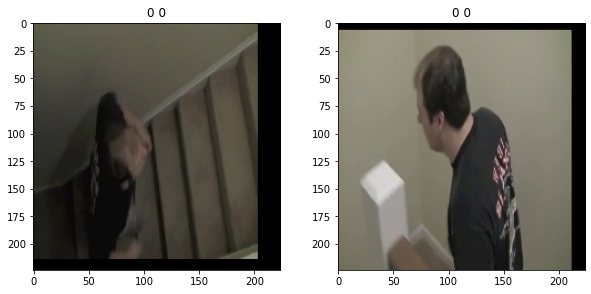

In [27]:
plt.figure(figsize=(10, 10))
for ii, img in enumerate(imgs[::4]):
    plt.subplot(2, 2, ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(str(label-1) + ' ' + str(label1-1))
plt.show()

In [28]:
val_ds = VideoDataset(ids=valid_ids, labels=valid_labels_v, labels1=valid_labels_a,transform=val_transform)
print(len(val_ds))

615


In [29]:
imgs, label, labels1 = val_ds[5]
print(imgs.shape, label-1, label1-1, torch.min(imgs), torch.max(imgs))

torch.Size([8, 3, 224, 224]) 0 0 tensor(-2.1179) tensor(2.6400)


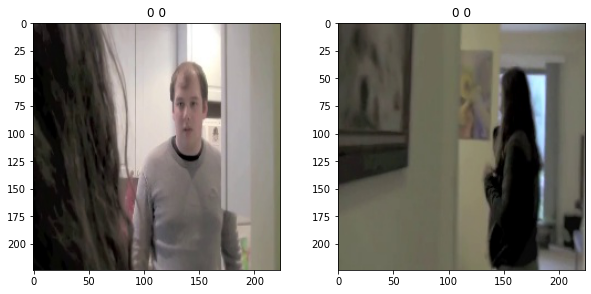

In [30]:
plt.figure(figsize=(10, 10))
for ii, img in enumerate(imgs[::4]):
    plt.subplot(2, 2, ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(str(label-1) + ' ' + str(label1-1))
plt.show()

In [31]:
test_ds = VideoDataset(ids=test_ids, labels=test_labels_v, labels1=test_labels_a,transform=val_transform)
print(len(test_ds))

4756


In [32]:
imgs, label, labels1 = test_ds[5]
print(imgs.shape, label-1, label1-1, torch.min(imgs), torch.max(imgs))

torch.Size([8, 3, 224, 224]) 1 0 tensor(-2.1179) tensor(2.2489)


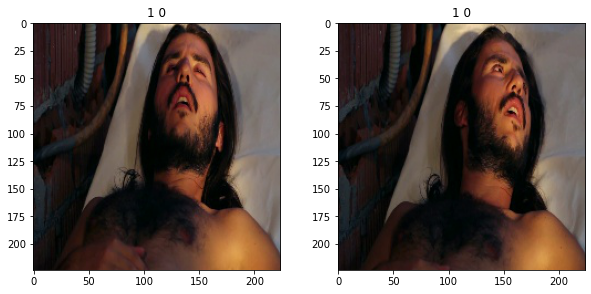

In [33]:
plt.figure(figsize=(10, 10))
for ii, img in enumerate(imgs[::4]):
    plt.subplot(2, 2, ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(str(label-1) + ' ' + str(label1-1))
plt.show()

# dataloader

In [34]:
def collate_fn_rnn(batch):
    imgs_batch, label_batch, label1_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    label1_batch = [torch.tensor(l) for l, imgs in zip(label1_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    labels1_tensor = torch.stack(label1_batch)
    return imgs_tensor,labels_tensor, labels1_tensor

In [35]:
batch_size = 16

train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=4, pin_memory=True,
                          shuffle=True, collate_fn=collate_fn_rnn, drop_last=True)

val_dl = DataLoader(val_ds, batch_size=batch_size, num_workers=4, pin_memory=True,
                          shuffle=True, collate_fn=collate_fn_rnn, drop_last=True)

test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=4, pin_memory=True,
                         shuffle=False, collate_fn=collate_fn_rnn, drop_last=True)

for xb, yb, yb1 in train_dl:
    print(xb.shape, yb.shape, yb1.shape)
    break
    
for xb, yb,yb1 in val_dl:
    print(xb.shape, yb.shape, yb1.shape)
    break    

for xb, yb, yb1 in test_dl:
    print(xb.shape, yb.shape, yb1.shape)
    break

torch.Size([16, 8, 3, 224, 224]) torch.Size([16]) torch.Size([16])
torch.Size([16, 8, 3, 224, 224]) torch.Size([16]) torch.Size([16])
torch.Size([16, 8, 3, 224, 224]) torch.Size([16]) torch.Size([16])


In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model

In [37]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models


class ContextGating(nn.Module):
    def __init__(self, input_num):
        super(ContextGating, self).__init__()
        self.sigmoid = nn.Sigmoid()
        self.linear = nn.Linear(input_num, input_num)
    
    def forward(self, x):
        lin = self.linear(x)
        sig = self.sigmoid(lin)
        res = x * sig
        return res
    

class Visual_CNN(nn.Module):
    def __init__(self, drop_prob=0.3, pretrained=True, num_layers=3, num_classes=3):
        super(Visual_CNN, self).__init__()
        
        self.pretrained = pretrained
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.num_classes = num_classes
        
        # cnn resnet
        pretrained_cnn = models.resnet101(pretrained=self.pretrained)
        cnn_layers = list(pretrained_cnn.children())[:-1]
        self.cnn = nn.Sequential(*cnn_layers)
        
        # context gating
        self.gate = ContextGating(2048)
        
        # cnn as feature extractor
        for param in self.cnn.parameters():
            param.requires_grad = False
        
        # intermediate_fc
        self.intermediate_fc = nn.Sequential(
                nn.Linear(2048 * 2, 2048),
                ContextGating(2048))
        
        # lstm
        self.LSTM = nn.LSTM(input_size=2048, hidden_size=1024, num_layers=self.num_layers, batch_first=True)
        self.Dropout = nn.Dropout(p=self.drop_prob)
        self.w = nn.Parameter(torch.ones(8),requires_grad=True)
        
        # fc
        self.down_fc = nn.Sequential(
                nn.Linear(2048+1024, 2048),
                ContextGating(2048))
        
        self.fc_valence = nn.Sequential(
                nn.Linear(2048, 3),
                ContextGating(3))
        
        self.fc_arousal = nn.Sequential(
                nn.Linear(2048, 3),
                ContextGating(3))
        
    
    def forward(self, x_3d):
        
        cnn_embedding_out = []
        
        for t in range(x_3d.size(1)):
            x = self.cnn(x_3d[:, t, :, :, :])
            x = torch.flatten(x, start_dim=1)
            
            # context gating
            x = self.gate(x)
            cnn_embedding_out.append(x)
        
        frame_out = torch.stack(cnn_embedding_out, dim=0)
        cnn_embedding_out = torch.stack(cnn_embedding_out, dim=0).transpose(0, 1)
        
        lstm_f = cnn_embedding_out
        
        # lstm
        lstm_out, _ = self.LSTM(lstm_f)
        vecs = []
        seqlen = lstm_out.size(1)
        for s in range(seqlen):
            vec = self.Dropout(lstm_out[:, s, :]) * self.w[s]
            vecs.append(vec)
        
        lstm_out = torch.stack(vecs, dim=1)
        lstm_out = torch.mean(lstm_out, dim=1)
        
        # video-level mean and std
        x1 = torch.mean(frame_out, 0)
        tmp = frame_out.detach().cpu().numpy()
        x2 = np.std(tmp, axis=0)
        x2 = np.nan_to_num(x2)
        x2 = torch.from_numpy(x2).to(device)
        v_fea = torch.cat([x1, x2], dim=1)
        v_fea = F.normalize(v_fea, p=2, dim=1)
        v_fea = self.intermediate_fc(v_fea)
        
        # fusion
        out = torch.cat([lstm_out, v_fea], dim=1)
        out = F.normalize(out, p=2, dim=1)
        out = self.down_fc(out)
        
        # classifier
        valence = self.fc_valence(out)
        arousal = self.fc_arousal(out)
        
        return valence, arousal

In [38]:
model = Visual_CNN()
model.to(device)
model

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Visual_CNN(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

In [39]:
# calculate accuracy
def calculat_acc(output, target):
    output = nn.functional.softmax(output, dim=1)
    output = torch.argmax(output, dim=1)
    return (output == target).float().mean()

In [40]:
# valence class weights
w1, w2, w3 = 1. / np.log(data_t['v_class'].value_counts())
weights_v = [w1, w2 ,w3]
weights_v

[0.1296080601083177, 0.129683162928429, 0.13478214101892214]

In [41]:
#arousal class weights
w11, w22, w33 = 1. / np.log(data_t['a_class'].value_counts())
weights_a = [w11, w22 ,w33]
weights_a

[0.12108470346656956, 0.13778455188364686, 0.14789458520859397]

# train

In [42]:
# train

max_epoch = 10
best_acc_v = 0.
best_acc_a = 0.
valid_accs_v = []
valid_accs_a = []
valid_losses = []
lowest_val_loss = np.inf
lr = 3e-4

class_weights_v = torch.FloatTensor(weights_v).to(device)
class_weights_a = torch.FloatTensor(weights_a).to(device)

criterion_v = nn.CrossEntropyLoss(weight=class_weights_v)
criterion_a = nn.CrossEntropyLoss(weight=class_weights_a)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0., amsgrad=True)


for epoch in range(1, max_epoch+1):
    print('Epoch:', epoch)
    loss_history = []
    model.train()
    for img, target,target1 in tqdm(train_dl):
        img = img.to(device)
        target = target.to(device)
        target1 = target1.to(device)
        
        output = model(img)
        
        loss_v = criterion_v(output[0], target)
        
        loss_a = criterion_a(output[1], target1)
        
        loss = loss_v + loss_a
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_history.append(float(loss))
    
    print('train_loss: {:.4}'.format(torch.mean(torch.Tensor(loss_history))))
    
    loss_history = []
    acc_history_v = []
    acc_history_a = []
    model.eval()
    for img, target, target1 in tqdm(val_dl):
        img = img.to(device)
        target = target.to(device)
        target1 = target1.to(device)
        
        output = model(img)
        
        loss_v = criterion_v(output[0], target)
        
        loss_a = criterion_a(output[1], target1)
        
        loss = loss_v + loss_a
        
        valence = output[0]
        arousal = output[1]
        
        acc_v = calculat_acc(valence, target)
        acc_history_v.append(float(acc_v))
        
        acc_a = calculat_acc(arousal, target1)
        acc_history_a.append(float(acc_a))
        
        loss_history.append(float(loss))

    print('valid_loss: {:.4}|valid_acc_v: {:.4}|valid_acc_a: {:.4}'.format(
            torch.mean(torch.Tensor(loss_history)),
            torch.mean(torch.Tensor(acc_history_v)),
            torch.mean(torch.Tensor(acc_history_a)),
            ))
    
    valid_acc_v = torch.mean(torch.Tensor(acc_history_v))
    valid_acc_a = torch.mean(torch.Tensor(acc_history_a))
    valid_loss =  torch.mean(torch.Tensor(loss_history))
    
    valid_accs_v.append(valid_acc_v)
    valid_accs_a.append(valid_acc_a)
    valid_losses.append(valid_loss)
    
    torch.save(model.state_dict(), 'visual-cnn_%d.pth' % (epoch), _use_new_zipfile_serialization=False)

  0%|          | 0/345 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/38 [00:00<?, ?it/s]

train_loss: 2.045


100%|██████████| 38/38 [00:22<00:00,  1.72it/s]


valid_loss: 1.998|valid_acc_v: 0.4112|valid_acc_a: 0.625


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/38 [00:00<?, ?it/s]

train_loss: 1.983


100%|██████████| 38/38 [00:21<00:00,  1.79it/s]


valid_loss: 1.975|valid_acc_v: 0.4342|valid_acc_a: 0.6266


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/38 [00:00<?, ?it/s]

train_loss: 1.965


100%|██████████| 38/38 [00:21<00:00,  1.78it/s]


valid_loss: 1.968|valid_acc_v: 0.4359|valid_acc_a: 0.6299


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/38 [00:00<?, ?it/s]

train_loss: 1.957


100%|██████████| 38/38 [00:20<00:00,  1.83it/s]


valid_loss: 1.962|valid_acc_v: 0.4408|valid_acc_a: 0.6382


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/38 [00:00<?, ?it/s]

train_loss: 1.935


100%|██████████| 38/38 [00:21<00:00,  1.81it/s]


valid_loss: 1.961|valid_acc_v: 0.4441|valid_acc_a: 0.6266


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/38 [00:00<?, ?it/s]

train_loss: 1.922


100%|██████████| 38/38 [00:22<00:00,  1.68it/s]


valid_loss: 1.998|valid_acc_v: 0.4391|valid_acc_a: 0.6266


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/38 [00:00<?, ?it/s]

train_loss: 1.92


100%|██████████| 38/38 [00:22<00:00,  1.69it/s]


valid_loss: 1.983|valid_acc_v: 0.4243|valid_acc_a: 0.6086


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/38 [00:00<?, ?it/s]

train_loss: 1.915


100%|██████████| 38/38 [00:22<00:00,  1.72it/s]


valid_loss: 1.955|valid_acc_v: 0.4424|valid_acc_a: 0.6299


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/38 [00:00<?, ?it/s]

train_loss: 1.903


100%|██████████| 38/38 [00:21<00:00,  1.79it/s]


valid_loss: 1.984|valid_acc_v: 0.4375|valid_acc_a: 0.6086


  0%|          | 0/345 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/38 [00:00<?, ?it/s]

train_loss: 1.9


100%|██████████| 38/38 [00:23<00:00,  1.62it/s]


valid_loss: 1.956|valid_acc_v: 0.4556|valid_acc_a: 0.6102


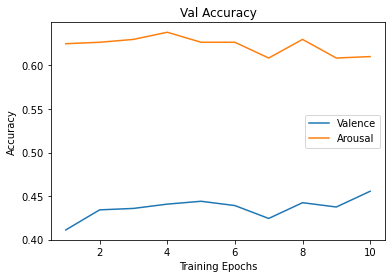

In [43]:
# vis accuracy
valid_accs_v = [i.item() for i in valid_accs_v]
valid_accs_a = [i.item() for i in valid_accs_a]
plt.title("Val Accuracy")
plt.plot(range(1,epoch+1), valid_accs_v, label='Valence')
plt.plot(range(1,epoch+1), valid_accs_a, label='Arousal')
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [44]:
max(valid_accs_v), max(valid_accs_a)

(0.4555920958518982, 0.6381579041481018)

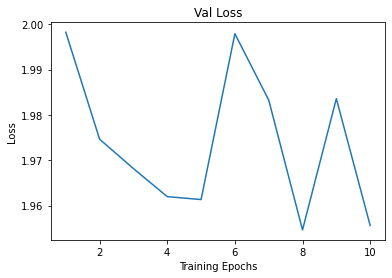

In [45]:
# vis loss
valid_losses = [i.item() for i in valid_losses]
plt.title("Val Loss")
plt.plot(range(1, epoch+1), valid_losses)
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.show()

# test

In [46]:
print('Test Accuracy:')
for epoch in range(1, max_epoch + 1):

    print('Epoch:', epoch)
    model = Visual_CNN()
    model.to(device)
    
    net_weights = torch.load('visual-cnn_%d.pth' % (epoch))
    model.load_state_dict(net_weights)
    model.eval()

    acc = 0.
    acc1 = 0.
    acc2 = 0.
    i = 0

    for data, label, label1 in tqdm(test_dl):
        img = data.to(device)
        label = label.to(device)
        label1 = label1.to(device)

        output = model(img)

        valence = output[0]
        arousal = output[1]

        output1 = nn.functional.softmax(valence, dim=1)
        output1 = torch.argmax(output1, dim=1)

        acc += (output1 == label).float().mean().item()

        output2 = nn.functional.softmax(arousal, dim=1)
        output2 = torch.argmax(output2, dim=1)

        acc1 += (output2 == label1).float().mean().item()

        i += 1

    print('Valence Video Test Accuracy:', acc / i)
    print('Arousal Video Test Accuracy:', acc1 / i)

    del model
    torch.cuda.empty_cache()

Test Accuracy:
Epoch: 1


100%|██████████| 297/297 [02:41<00:00,  1.84it/s]


Valence Video Test Accuracy: 0.3859427609427609
Arousal Video Test Accuracy: 0.5553451178451179
Epoch: 2


100%|██████████| 297/297 [02:34<00:00,  1.93it/s]


Valence Video Test Accuracy: 0.4255050505050505
Arousal Video Test Accuracy: 0.5553451178451179
Epoch: 3


100%|██████████| 297/297 [02:37<00:00,  1.89it/s]


Valence Video Test Accuracy: 0.41835016835016836
Arousal Video Test Accuracy: 0.5637626262626263
Epoch: 4


100%|██████████| 297/297 [02:37<00:00,  1.89it/s]


Valence Video Test Accuracy: 0.42908249158249157
Arousal Video Test Accuracy: 0.5629208754208754
Epoch: 5


100%|██████████| 297/297 [02:35<00:00,  1.91it/s]


Valence Video Test Accuracy: 0.4375
Arousal Video Test Accuracy: 0.5555555555555556
Epoch: 6


100%|██████████| 297/297 [02:32<00:00,  1.94it/s]


Valence Video Test Accuracy: 0.4335016835016835
Arousal Video Test Accuracy: 0.5641835016835017
Epoch: 7


100%|██████████| 297/297 [02:33<00:00,  1.94it/s]


Valence Video Test Accuracy: 0.41435185185185186
Arousal Video Test Accuracy: 0.5574494949494949
Epoch: 8


100%|██████████| 297/297 [02:33<00:00,  1.94it/s]


Valence Video Test Accuracy: 0.4436026936026936
Arousal Video Test Accuracy: 0.564604377104377
Epoch: 9


100%|██████████| 297/297 [02:34<00:00,  1.93it/s]


Valence Video Test Accuracy: 0.4252946127946128
Arousal Video Test Accuracy: 0.5513468013468014
Epoch: 10


100%|██████████| 297/297 [02:32<00:00,  1.95it/s]

Valence Video Test Accuracy: 0.44675925925925924
Arousal Video Test Accuracy: 0.5635521885521886
